In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import math
import random
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
import pandas
from matplotlib import cm
from matplotlib.colors import Normalize
from pandas import DataFrame as df
import numpy as np
import os

from tqdm.notebook import tqdm, trange
!jupyter nbextension enable --py widgetsnbextension

np.set_printoptions(precision=3, suppress=True)

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/drive/flim_lung.zip ./flim_lung.zip
# %cp -v "/content/drive/MyDrive/flim_lung.zip" "./flim_lung.zip"
# !unzip -q flim_lung.zip
# !ls flim_lung
# !rm -f flim_lung.zip

# drive.flush_and_unmount()
# print('All changes made in this colab session should now be visible in Drive.')

Mounted at /content/drive
cp: cannot stat '/content/drive/flim_lung.zip': No such file or directory
'/content/drive/MyDrive/flim_lung.zip' -> './flim_lung.zip'
ls: cannot access 'flim_lung': No such file or directory
All changes made in this colab session should now be visible in Drive.


In [3]:
# parameters

INTENSITY_MASK_THRESHOLD = 0.05 # after intensity normalized to [0, 1]

# hyper
BATCH_SIZE = 8
SHUFFLE_BUF_SIZE = 1000
TRAIN_PROPORTION = 0.8 # 80% training, 20% validation

In [4]:
def load_data(data_file="./sample_data/sample_data.csv"):
    # load data in csv file into DataFrame
    df = pandas.read_csv(data_file)
    print(f"Data loaded: {df.shape}")
    return df

#data = load_data('./dataset/20181023_lungtissue_normal_cancer_CR34.csv')
# data = load_data()

In [5]:
def parse_data(df_table: df):
    # parse data in DataFrame into numpy.ndarray
    assert (df_table is not None)

    tissue_class_column_np = [1 if x else 0 for x in df_table.loc[:, "tissue_classification"]] # label
    # 1 : tissue classification
    # 2 : band
    # 3 : exposure time

    pixel_starting = 4
    pixel_ending = len(df_table.columns)
    pixel_columns_np = df_table.iloc[:, pixel_starting:pixel_ending].values

    intensity_data = pixel_columns_np[:, 0:128 * 128] # first 128x128 pixels are intensity
    lifetime_data = pixel_columns_np[:, 128 * 128:pixel_columns_np.shape[1]] # the rest is lifetime

    return np.asarray(intensity_data), np.asarray(lifetime_data), np.asarray(tissue_class_column_np)

# intensity, lifetime, classes = parse_data(data) # each frame's lifetime and intensity shape: (16384, ), which is 128x128
# print("# Frames: ", intensity.shape[0])

In [6]:
# call once for each frame
def post_processing(intensity: np.ndarray, lifetime: np.ndarray):
    # replace nan with 0
    intensity[np.isnan(intensity)] = 0.0
    lifetime[np.isnan(lifetime)] = 0.0

    mask = (intensity > 0)
    # use root mean square of intensity as filter mask
    threshold = math.sqrt(np.ma.array(intensity, mask=mask).mean())
    # for all frames, pixels whose intensity below threshold have their lifetime and intensity is set to 0
    intensity[intensity < threshold] = 0     # i think this line is unnecessary ~

    for i in range(intensity.shape[0]):
        if intensity[i] < threshold:
            intensity[i] = 0
            lifetime[i] = 0

    lifetime[lifetime > 5] = 0 # lifetime too long are also ignored

    intensity = np.resize(intensity, (128, 128))
    lifetime = np.resize(lifetime, (128, 128))

    ## lifetime: grey to rgb
    mask = np.resize(mask.astype(int), (128, 128))
    norm = Normalize(vmin=0.0, vmax=1.0) # used to be 255.0
    lifetime_color = cm.jet(norm(lifetime))

    # --------
    lifetime_color_rgb = lifetime_color[:, :, 0:3] # essentially discards the alpha channel, only need RGB
    lifetime_color_rgb[:, :, 0] *= mask
    lifetime_color_rgb[:, :, 1] *= mask
    lifetime_color_rgb[:, :, 2] *= mask
    # ... what's the point of lifetime_color_rgb ??
    # --------

    # print((lifetime_color[:, :, 3]==1).all()) # all
    ## weighting
    bgcolor = 255 # white background
    intensity_alpha_mask = intensity/intensity.max() # normalize intensity to between 0 and 1
    intensity_alpha_mask[intensity_alpha_mask < INTENSITY_MASK_THRESHOLD] = 0 # those below 0.05 ignored
    lifetime_alpha_rgb = np.zeros(intensity_alpha_mask.shape + (3,)) # why not just lifetime_color_rgb.shape?
    # recalculate the rgb but incorporate the mask
    lifetime_alpha_rgb[:, :, 0] = ((1 - lifetime_color[:, :, 3]) * bgcolor) + intensity_alpha_mask * lifetime_color[:, :, 0]
    lifetime_alpha_rgb[:, :, 0] *= mask
    lifetime_alpha_rgb[:, :, 1] = ((1 - lifetime_color[:, :, 3]) * bgcolor) + intensity_alpha_mask * lifetime_color[:, :, 1]
    lifetime_alpha_rgb[:, :, 1] *= mask
    lifetime_alpha_rgb[:, :, 2] = ((1 - lifetime_color[:, :, 3]) * bgcolor) + intensity_alpha_mask * lifetime_color[:, :, 2]
    lifetime_alpha_rgb[:, :, 2] *= mask
    # print(np.zeros(lifetime_color_rgb.shape).shape)

    # lifetime_alpha_rgb: the main output for use
    return intensity, lifetime, lifetime_alpha_rgb, intensity_alpha_mask

# which frame to view
# index = 10
# temp_it, temp_lt, temp_lt_alpha, mask = post_processing(intensity[index], lifetime[index])
# temp_lt_alpha.shape

In [ ]:
image_list = []
label_list = []

# think: use np.concatenate([a, b]) instead?
# todo: loop for each csv

directory = './dataset'
c = 4 # only the first n CSV files
i = 0

for csv in os.listdir(directory):
    filename = os.path.join(directory, csv)
    # checking if it is a file
    if os.path.isfile(filename):
        print(filename)
        if i == c:
            break # skip the rest
        i += 1

        data = load_data(data_file=filename)
        intensity, lifetime, classes = parse_data(data)
        for frameIdx in trange(lifetime.shape[0]):
            temp_it, temp_lt, temp_lt_alpha, mask = post_processing(intensity[frameIdx], lifetime[frameIdx])
            image_list.append(temp_lt_alpha)
        label_list.append(classes)

features = np.array(image_list)
labels = np.concatenate(label_list)
print(len(features))

In [8]:
# import glob

# class CustomDataset(tf.keras.utils.Sequence):
#     def __init__(self, data_dir, sample_limit, batch_size, validation_split=0.2):
#         self.data_dir = data_dir
#         self.sample_limit = sample_limit
#         self.batch_size = batch_size
#         self.file_list = glob.glob(data_dir + '/*.csv')  # Assuming frames are in PNG format
#         self.num_samples = len(self.file_list)

#         self.validation_split = validation_split
#         self.train_frame_filenames, self.val_frame_filenames = train_test_split(
#             self.file_list, test_size=self.validation_split, random_state=42)

#     # returns the number of batches
#     def __len__(self):
#         # return int(tf.math.ceil(self.num_samples / self.batch_size))

#         if self.mode == 'train':
#             return math.ceil(len(self.train_frame_filenames) / self.batch_size) # self.batch_size
#         elif self.mode == 'val':
#             return math.ceil(len(self.val_frame_filenames) / self.batch_size) # self.batch_size

#     def __getitem__(self, idx):
#         # batch_files = self.file_list[idx * self.batch_size: (idx + 1) * self.batch_size]
#         if self.mode == 'train':
#             batch_files = self.train_frame_filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
#         else:
#             batch_files = self.val_frame_filenames[idx * self.batch_size: (idx + 1) * self.batch_size]

#         # frames
#         batch_frames = []
#         batch_labels = []

#         i = 0
#         for file_path in batch_files:
#             if i == self.sample_limit:
#                 break
#             i += 1

#             # Load frame
#             # frame = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale frames
#             # frame = frame / 255.0  # Normalize the frame values (0-255 to 0-1)
#             # batch_frames.append(frame)

#             # Extract label from file name (assuming file name format: 'label_frameXXX.png')
#             # label = int(file_path.split('_')[0])
#             # batch_labels.append(label)

#             data = load_data(data_file=file_path)
#             intensity, lifetime, classes = parse_data(data)
#             for frameIdx in trange(lifetime.shape[0]):
#                 temp_it, temp_lt, temp_lt_alpha, mask = post_processing(intensity[frameIdx], lifetime[frameIdx])
#                 batch_frames.append(temp_lt_alpha)
#                 del temp_it, temp_lt, temp_lt_alpha, mask
#             batch_labels.append(classes)

#         return np.array(batch_frames), np.array(batch_labels)

#     def set_mode(self, mode):
#         if mode not in ['train', 'val']:
#             raise ValueError("Invalid mode. Must be either 'train' or 'val'.")
#         self.mode = mode

# # Usage example
# data_dir = './'
# sample_limit = 4 # only load the first n csv
# batch_size = 1
# dataset = CustomDataset(data_dir, sample_limit, batch_size)

# # Iterate over the dataset
# # for frames, labels in dataset:
# #     # Perform further processing or use the frames and labels in your model training
# #     # frames shape: (batch_size, 128, 128)
# #     # labels shape: (batch_size,)
# #     print(f'{len(frames)}, label: {labels}')


Text(0.5, 1.0, 'Weighted lifetime')

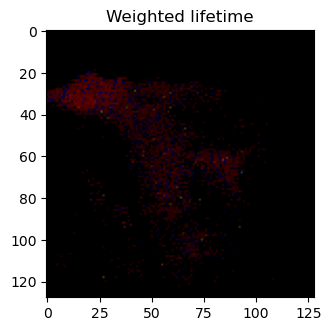

In [ ]:
# plt.subplot(155)
# plt.imshow(features[4], cmap="jet", vmin=0.5)
# plt.title("Weighted lifetime")

### Create a dataset

Define some parameters for the loader:

In [9]:
# batch_size = 3
img_height = 128
img_width = 128

In [ ]:
features.shape

(4326, 128, 128, 3)

In [10]:
import tensorflow as tf

# features = tf.constant(features)
# labels = tf.constant(labels)

# ds = tf.data.Dataset.from_tensor_slices(
#     (features, labels)
# )

# transform


# shuffle (done later)
# ds = ds.shuffle(SHUFFLE_BUF_SIZE, reshuffle_each_iteration=True)

# batch
# ds = ds.batch(BATCH_SIZE)

# split
train_ds, val_ds = tf.keras.utils.split_dataset(dataset, left_size=TRAIN_PROPORTION)
int(train_ds.cardinality())


TypeError: ignored

## Visualize the data

Here are the first nine images from the training dataset:

In [ ]:
images = list(ds.as_numpy_iterator())
images[0][0].shape

(64, 128, 128, 3)

/tmp/ipykernel_826894/3523736039.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 5, i+1)


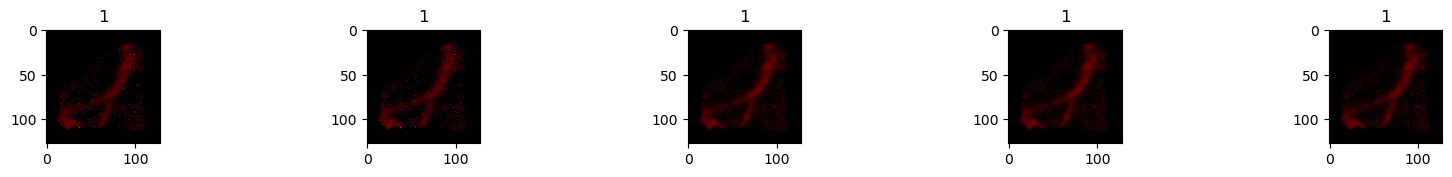

In [ ]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"), cmap="hot")
#     # plt.title(class_names[labels[i]])
#     plt.axis("off")

images = list(ds.as_numpy_iterator())
# plt.subplot(155)
# plt.imshow(images[0][0], cmap="jet", vmin=0.5)
plt.title("Weighted lifetime")
# for i in range(min(len(images), 15)):
#     ax = plt.subplot(3, 5, i+1)
#     plt.imshow(images[i][0], cmap="jet")
#     plt.title(images[i][1])
batch_idx = random.randint(0, len(features) // BATCH_SIZE)
for i in range(min(BATCH_SIZE, 15)):
    ax = plt.subplot(3, 5, i+1)
    plt.imshow(images[batch_idx][0][i], cmap="jet")
    plt.title(images[batch_idx][1][i])
# todo: remove the textual representation of the tensors

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 128, 128, 3)
(64,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [ ]:
# normalization_layer = layers.Rescaling(1./255)
normalization_layer = layers.Rescaling(1) # since already done earlier

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

nan nan


## A basic Keras model

In [11]:
num_classes = 2

model = Sequential([
  # layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # layers.Conv2D(16, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  # layers.Conv2D(32, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  # layers.Conv2D(64, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  # layers.Flatten(),
  # layers.Dense(128, activation='relu'),
  # layers.Dense(num_classes)

  layers.Conv2D(2, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(4, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(4, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [13]:
model.build((None, img_height, img_width, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 2)       56        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 4)         76        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 4)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         296       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 8)        0

### Train the model

In [ ]:
len(train_ds)

13

In [17]:
epochs=4

dataset.set_mode('train')
history = model.fit(
  dataset,
  epochs=epochs
)

Data loaded: (2616, 32772)


  0%|          | 0/2616 [00:00<?, ?it/s]

<ipython-input-6-f685ef3745b4>:9: UserWarning: Warning: converting a masked element to nan.
  threshold = math.sqrt(np.ma.array(intensity, mask=mask).mean())


Data loaded: (516, 32772)


  0%|          | 0/516 [00:00<?, ?it/s]

<ipython-input-6-f685ef3745b4>:9: UserWarning: Warning: converting a masked element to nan.
  threshold = math.sqrt(np.ma.array(intensity, mask=mask).mean())
<ipython-input-8-9eba57ecd468>:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(batch_frames), np.array(batch_labels)


ValueError: ignored

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

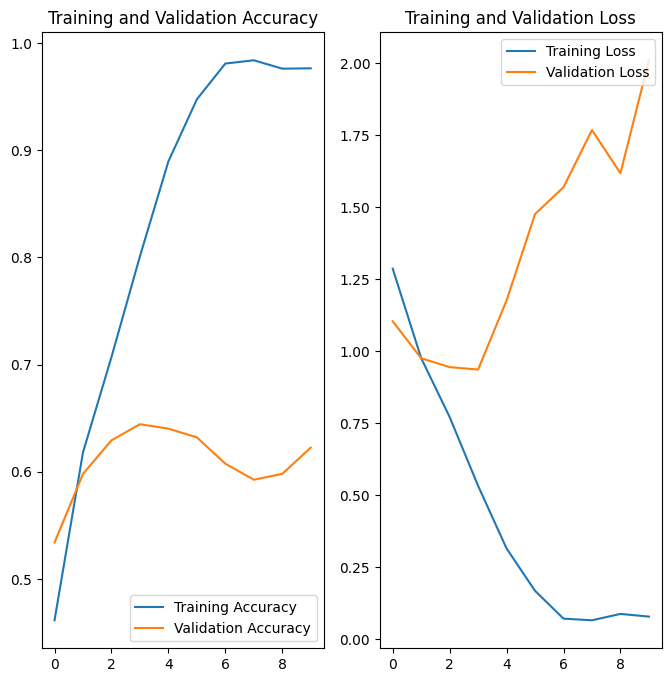

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

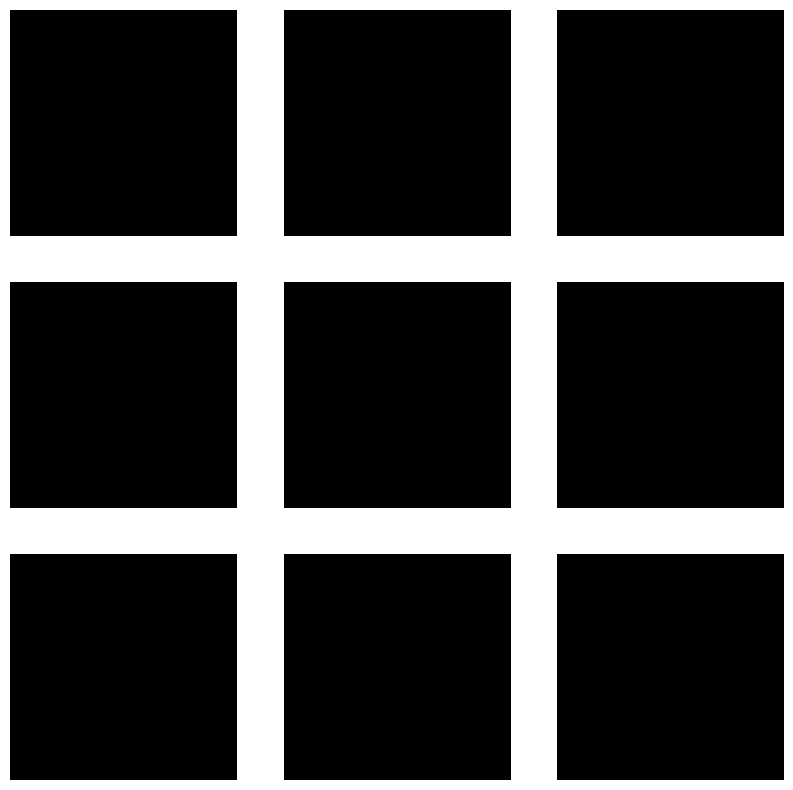

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [ ]:
epochs = 3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
155/155 [==============================] - 14s 92ms/step - loss: nan - accuracy: 0.4230 - val_loss: nan - val_accuracy: 0.4819
Epoch 2/3
155/155 [==============================] - 13s 84ms/step - loss: nan - accuracy: 0.4230 - val_loss: nan - val_accuracy: 0.4819
Epoch 3/3
155/155 [==============================] - 13s 85ms/step - loss: nan - accuracy: 0.4230 - val_loss: nan - val_accuracy: 0.4819


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

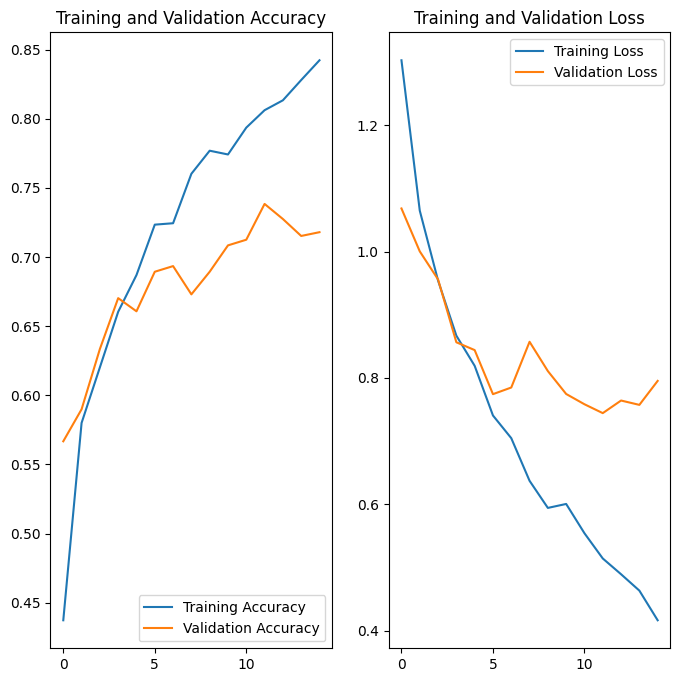

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


  8192/117948 [=>............................] - ETA: 0s


117948/117948 [==============================] - 0s 0us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 125ms/step


This image most likely belongs to sunflowers with a 97.33 percent confidence.


## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpr2jwfqh7/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpr2jwfqh7/assets


2022-12-14 02:30:14.950940: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-14 02:30:14.950996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [ ]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 97.33 percent confidence.


The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

1.4305115e-06


Of the five classes—`'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'`, and `'tulips'`—the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).